## Assignment 2 - Exploration of patterns in the data

### Energy Demand based on time data

Energy Demand (Regression): Heavily dependant on seasonal patterns (time-of-day, day-of-week, time-of-year), and partly on weather

Descriptive model : Model the relationship between time and demand
Predictive model : Since predicting the time as a given time in the future is trivial, this is almost for free. Different types include Long-term Load Forecasting (months-ahead), Short-term Load Forecasting (day-head or week-ahead), and Ultra Short-term Load Forecasting (hours-ahead).

I have decided explore demand as a function of time features. I will first look at the 

In [1]:
# import what has to be
from influxdb import InfluxDBClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from energy_gen_forecast import mytransformers
plt.style.use('seaborn')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

In [2]:
# create client
client = InfluxDBClient(host = 'influxus.itu.dk', port = 8086, username = 'lsda', password = 'icanonlyread')
client.switch_database('orkney')

In [3]:
client.get_list_measurements()

[{'name': 'ANM_Operation'},
 {'name': 'Demand'},
 {'name': 'Generation'},
 {'name': 'Generator_Site_Issues'},
 {'name': 'SHEPD_Equipment'},
 {'name': 'Temperature'},
 {'name': 'Wind'}]

In [4]:
# get demand data for exploration
results = client.query('SELECT Total FROM "Demand" WHERE time > now() - 200w')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_df = pd.DataFrame(values, columns = columns).set_index("time")

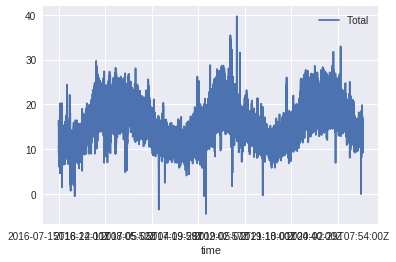

In [5]:
demand_df.plot()

In [6]:
demand_df.head()

,Total
time,
2016-07-15T18:24:00Z,15.15
2016-07-15T18:25:00Z,15.37
2016-07-15T18:26:00Z,15.94
2016-07-15T18:27:00Z,16.40
2016-07-15T18:28:00Z,15.56


In [7]:
results = client.query('SELECT mean(Total) FROM "Demand" WHERE time > now() - 200w GROUP BY time(1h)')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_mean_df = pd.DataFrame(values, columns = columns).set_index("time")

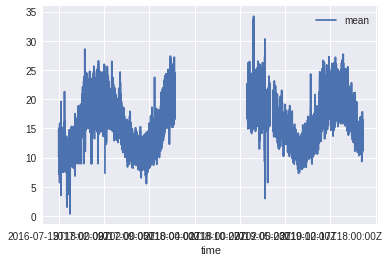

In [8]:
demand_mean_df.plot()

## Preprocessing Pipeline

In [9]:
# preprocessing pipeline
pre_pipeline = Pipeline([
    ('date_worker', mytransformers.DateTransformer()),
    ('shifter', mytransformers.Shifter())
])

In [10]:
# apply pipeline
processed_data = pre_pipeline.fit_transform(demand_df, shifter__weeks = 2)
features = processed_data[0]
labels = processed_data[0]

In [11]:
features.head()

,time,Total,year,month,day,hour,minute,day_of_week,1weekback,2weekback
datetime,,,,,,,,,,
2016-07-29 18:24:00,2016-07-29T18:24:00Z,10.08,2016,7,29,18,24,4,11.53,15.15
2016-07-29 18:25:00,2016-07-29T18:25:00Z,10.89,2016,7,29,18,25,4,11.53,15.37
2016-07-29 18:26:00,2016-07-29T18:26:00Z,10.21,2016,7,29,18,26,4,11.53,15.94
2016-07-29 18:27:00,2016-07-29T18:27:00Z,12.14,2016,7,29,18,27,4,11.53,16.40
2016-07-29 18:28:00,2016-07-29T18:28:00Z,11.42,2016,7,29,18,28,4,11.53,15.56


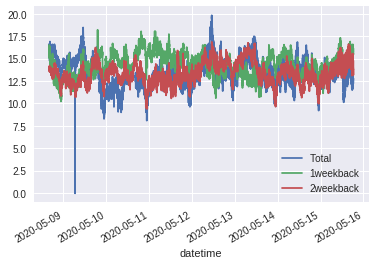

In [12]:
features[['Total', '1weekback', '2weekback']].iloc[-10000:].plot()
plt.savefig('1dayback.png')

In [13]:
trustworthy_test_df = features.groupby(['year', 'month', 'day', 'hour']).count()

In [14]:
trustworthy_test_df[trustworthy_test_df['minute'] != 60]

time  Total  minute  day_of_week  1weekback  2weekback
year month day hour                                                        
2016 7     29  18      33     33      33           33         33         33
               19      43     43      43           43         43         43
               20      43     43      43           43         43         43
               21      37     37      37           37         37         37
               22      48     48      48           48         48         48
...                   ...    ...     ...          ...        ...        ...
2020 5     14  11      59     59      59           59         59         59
               18      58     58      58           58         58         58
           15  1       49     49      49           49         49         49
               2       46     46      46           46         46         46
               18      24     24      24           24         24         24

[13894 rows x 6 columns]

In [15]:
trustworthy_test_df[trustworthy_test_df['minute'] == 60]

time  Total  minute  day_of_week  1weekback  2weekback
year month day hour                                                        
2016 12    12  6       60     60      60           60         60         60
2017 10    5   19      60     60      60           60         60         60
           12  19      60     60      60           60         60         60
           15  12      60     60      60           60         60         60
           19  19      60     60      60           60         60         60
...                   ...    ...     ...          ...        ...        ...
2020 5     15  13      60     60      60           60         60         60
               14      60     60      60           60         60         60
               15      60     60      60           60         60         60
               16      60     60      60           60         60         60
               17      60     60      60           60         60         60

[7293 rows x 6 columns]

So most of the time it is correct, but I don't think I can trust this.

## Explorations

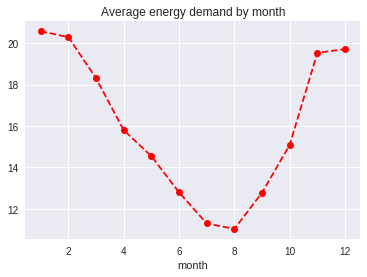

In [16]:
# plot average year
features.groupby(['month']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by month')
plt.savefig('monthly_seasonality.png')

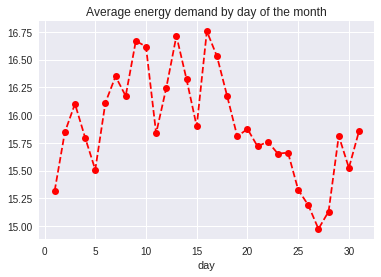

In [17]:
# plot average month
features.groupby(['day']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the month')
plt.savefig('daily_seasonality.png')

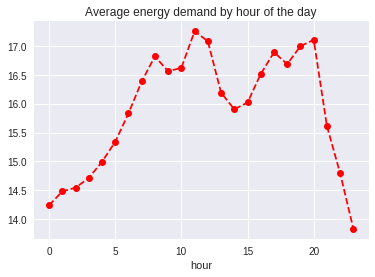

In [18]:
# plot average day
features.groupby(['hour']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by hour of the day')
plt.savefig('hourly_seasonality.png')

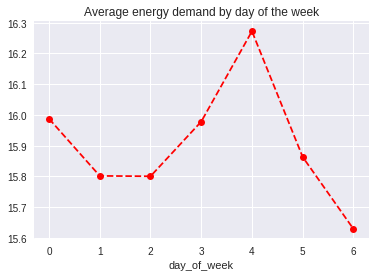

In [19]:
features.groupby(['day_of_week']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the week')
plt.savefig('weekly_seasonality.png')

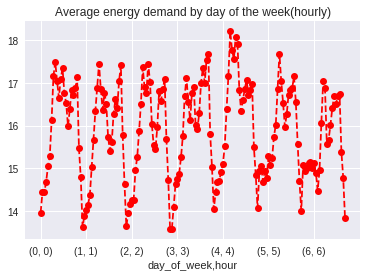

In [20]:
features.groupby(['day_of_week', 'hour']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the week(hourly)')
plt.savefig('weekly_seasonality_hours.png')

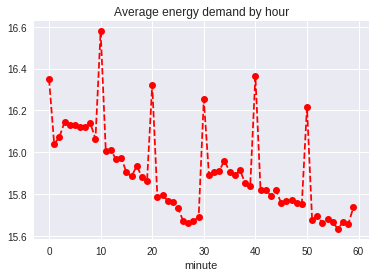

In [21]:
# plot average hour
features.groupby(['minute']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by hour')
plt.savefig('hourly_seasonality.png')

# Is the hourly mean far off from the values

In [22]:
demand_hourly_mean_df = features.groupby(['year', 'month', 'day', 'hour']).mean()['Total']
#for i in range(4)[::-1]:
#    demand_hourly_mean_df = demand_hourly_mean_df.reset_index(level = i)

In [23]:
demand_hourly_mean_df

year  month  day  hour
2016  7      29   18      10.761818
                  19      10.446047
                  20      11.058837
                  21      10.354865
                  22      10.417292
                            ...    
2020  5      15   14      13.057500
                  15      13.893000
                  16      13.588000
                  17      12.493167
                  18      12.836667
Name: Total, Length: 21187, dtype: float64

In [24]:
demand_hourly_std_df = features.groupby(['year', 'month', 'day', 'hour']).std()['Total']

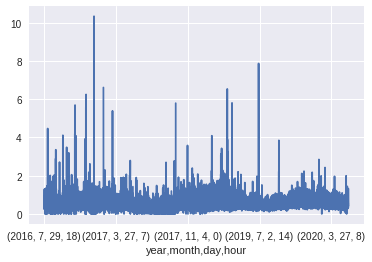

In [25]:
demand_hourly_std_df.plot()

In [26]:
mean_diff_df = features.reset_index(level = 0).set_index(['year', 'month', 'day', 'hour']).join(demand_hourly_mean_df, rsuffix= 'm_')

In [27]:
mean_diff_df['diff_from_mean'] = mean_diff_df['Total'] - mean_diff_df['Totalm_']

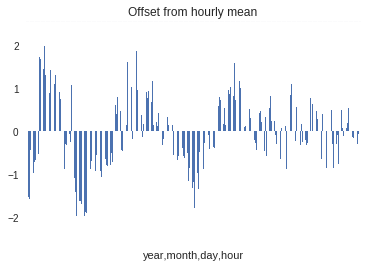

In [28]:
mean_diff_df['diff_from_mean'].iloc[-400:].plot.bar()
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.title('Offset from hourly mean')
plt.savefig('off_set_from_hourly_mean.png')

In [29]:
mean_absolute_error(mean_diff_df['Total'], mean_diff_df['Totalm_'])

0.45536483044161224

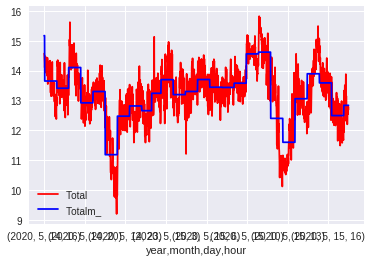

In [30]:
mean_diff_df[['Total', 'Totalm_']].iloc[-1500:].plot(color = ['r', 'b'])
plt.savefig('hourly_mean_vs_actual.png')

In [31]:
np.sqrt(mean_squared_error(mean_diff_df['Total'], mean_diff_df['Totalm_']))

0.61657183678885

In [32]:
for i in range(4)[::-1]:
    demand_hourly_mean_df = demand_hourly_mean_df.reset_index(level = i)
demand_hourly_mean_df

,year,month,day,hour,Total
0,2016,7,29,18,10.761818
1,2016,7,29,19,10.446047
2,2016,7,29,20,11.058837
3,2016,7,29,21,10.354865
4,2016,7,29,22,10.417292
...,...,...,...,...,...
21182,2020,5,15,14,13.057500
21183,2020,5,15,15,13.893000
21184,2020,5,15,16,13.588000
21185,2020,5,15,17,12.493167


In [33]:
mean_pipeline = Pipeline([
    ('date_worker', mytransformers.DateTransformer()),
    ('aggregator', mytransformers.HourlyAggregator()),
    ('onehot', mytransformers.DummyEncoder()),
    ('dateFeatures', mytransformers.DateTrendsAdder()),
    ('shifter', mytransformers.Shifter())
])

In [34]:
mean_processed = mean_pipeline.fit_transform(demand_df, shifter__weeks = 2)
mean_features = mean_processed[0].copy()

In [35]:
mean_processed[0][['is_day', 'is_week_day', 'day_of_week', 'distance_from_july']].head(72)

,is_day,is_week_day,day_of_week,distance_from_july
datetime,,,,
2016-07-29 18:00:00,1,1,4,0
2016-07-29 19:00:00,1,1,4,0
2016-07-29 20:00:00,1,1,4,0
2016-07-29 21:00:00,0,1,4,0
2016-07-29 22:00:00,0,1,4,0
...,...,...,...,...
2016-08-02 13:00:00,1,1,1,1
2016-08-02 14:00:00,1,1,1,1
2016-08-02 15:00:00,1,1,1,1


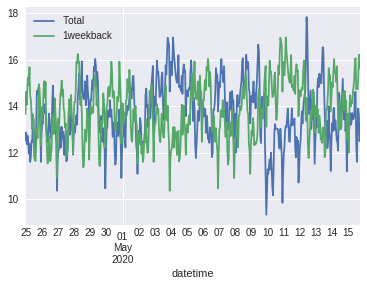

In [36]:
mean_processed[0][['Total', '1weekback']].iloc[-500:].plot()

# Model Building
## Establishing Baseline

In [37]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

## Testing 1 day ahead model

In [38]:
tscv = TimeSeriesSplit(5)
mean_features = mean_processed[0].copy()
labels = mean_features.pop('Total')
base_col_list = ['1weekback', '2weekback']
for train_idx, test_idx in tscv.split(labels):
    print('\nNew Round\n')
    X_train, X_test = mean_features.iloc[train_idx], mean_features.iloc[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    print('Baseline')
    rmse, mae, r2 = eval_metrics(y_test, X_test['1weekback'])
    print(f"rmse: {rmse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")
    
    X_train = X_train.drop(['1weekback','2weekback'], axis = 1)
    X_test = X_test.drop(['1weekback', '2weekback'], axis = 1)

    print('\nLasso')
    model = Lasso(0.5).fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, preds)
    print(f"rmse: {rmse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")
    for col, val in zip(X_train.columns, model.coef_):
        print(f"{col}\t{val}")

    print('\nRidge')
    model = Ridge(0.5).fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, preds)
    print(f"rmse: {rmse}")
    print(f"mae: {mae}")
    print(f"r2: {r2}")

    #print('\nDecisionTreeRegressor')
    #model = DecisionTreeRegressor().fit(X_train, y_train)
    #preds = model.predict(X_test)
    #rmse, mae, r2 = eval_metrics(y_test, preds)
    #print(f"rmse: {rmse}")
    #print(f"mae: {mae}")
    #print(f"r2: {r2}")
    #for col, val in zip(X_train.columns, model.feature_importances_):
    #    print(f"{col}\t{val}")



New Round

Baseline
rmse: 2.1827744754406986
mae: 1.673223530544627
r2: 0.5760503795879018

Lasso
rmse: 3.3972085452303644
mae: 2.863621803696678
r2: -0.026930217224424124
year	0.0
month	0.1786790240610221
day	0.01896268241948835
hour	0.08119229803539511
day_of_week	-0.0
year_2016	0.0
year_2017	-0.0
year_2018	0.0
year_2019	0.0
year_2020	0.0
month_1	-0.0
month_2	0.0
month_3	0.0
month_4	0.0
month_5	0.0
month_6	0.0
month_7	0.0
month_8	0.0
month_9	-0.0
month_10	-0.0
month_11	0.0
month_12	-0.0
day_1	-0.0
day_2	-0.0
day_3	-0.0
day_4	-0.0
day_5	0.0
day_6	0.0
day_7	0.0
day_8	0.0
day_9	-0.0
day_10	0.0
day_11	-0.0
day_12	0.0
day_13	0.0
day_14	0.0
day_15	-0.0
day_16	0.0
day_17	0.0
day_18	0.0
day_19	0.0
day_20	-0.0
day_21	0.0
day_22	-0.0
day_23	-0.0
day_24	-0.0
day_25	-0.0
day_26	-0.0
day_27	-0.0
day_28	0.0
day_29	0.0
day_30	0.0
day_31	0.0
hour_0	-0.0
hour_1	-0.0
hour_2	-0.0
hour_3	-0.0
hour_4	-0.0
hour_5	-0.0
hour_6	-0.0
hour_7	0.0
hour_8	0.0
hour_9	0.0
hour_10	0.0
hour_11	0.0
hour_12	0.0
hour_1

In [39]:
from tensorflow import keras

In [40]:
mean_features = mean_processed[0].copy()
corr_with_total = mean_features.corr(method = 'pearson')['Total'].sort_values()

In [41]:
corr_with_total[corr_with_total >  0.15]

month_3               0.164595
year_2020             0.166828
year                  0.201036
month_2               0.231931
is_day                0.238442
month_11              0.266707
month_12              0.303922
month_1               0.316603
distance_from_july    0.774828
2weekback             0.785997
1weekback             0.819798
Total                 1.000000
Name: Total, dtype: float64

In [42]:
corr_with_total[corr_with_total <  -0.15]

month_8     -0.380562
month_7     -0.309852
month_9     -0.271165
month_6     -0.198193
year_2016   -0.160901
Name: Total, dtype: float64